In [1]:
from astropy.io import fits

ff = fits.open('ngc6101/hlsp_hugs_hst_acs-wfc_ngc6101_f606w_v1_stack-0035s.fits')
print(ff)

In [2]:
im_data = ff[0].data
print(im_data)

[[-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]
 ...
 [-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]]


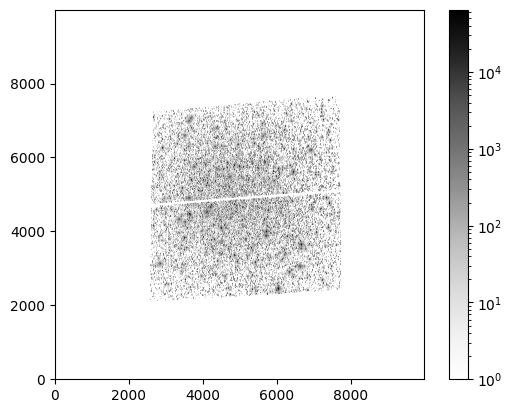

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure()
plt.imshow(im_data, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()

In [4]:
ff.info()

Filename: ngc6101/hlsp_hugs_hst_acs-wfc_ngc6101_f606w_v1_stack-0035s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (10000, 10000)   float32   


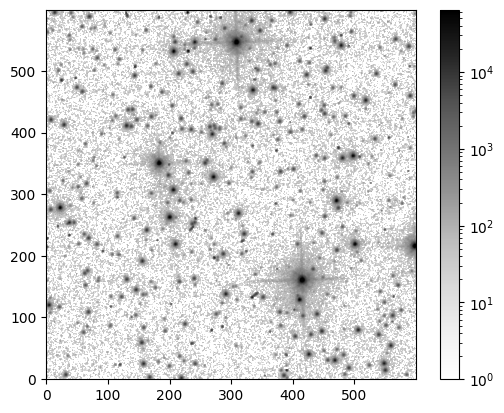

In [12]:
#section1 = im_data[2400:2600, 5650:5950]
#section1 = im_data[3000:3600, 5000:5600]
section1 = im_data[2000:8000, 2000:8000]

plt.figure()
plt.imshow(section1, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()

In [13]:
from astropy.stats import sigma_clipped_stats 

mean, median, std = sigma_clipped_stats(section1, sigma= 3.0)
print(mean, median, std)

12.728264 10.0 49.734608


In [14]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std)
sources1 = daofind(section1 - median)
for col in sources1.colnames:
    if col not in ('id', 'npix'):
        sources1[col].info.format = '%.2f'

sources1.pprint(max_width = 76)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1    411.37      0.40      0.74      -0.14 ... 0.00   504.00   1.62 -0.52
  2    219.20      1.13      0.53       0.16 ... 0.00 12677.00  43.40 -4.09
  3    390.35      1.62      0.54       0.78 ... 0.00  1602.00   5.51 -1.85
  4    167.68      2.33      0.54      -0.29 ... 0.00  7705.00  26.15 -3.54
  5    354.57      5.01      0.73      -0.26 ... 0.00  1780.00   6.45 -2.02
  6    385.46      5.40      0.40      -0.38 ... 0.00  7672.00  26.08 -3.54
  7     31.87      6.50      0.45      -0.15 ... 0.00  7720.00  26.83 -3.57
  8    484.26      7.35      0.66       0.34 ... 0.00  2172.00   6.25 -1.99
  9    584.62      6.76      0.70       0.26 ... 0.00  2556.00   7.25 -2.15
 10    225.52     10.81      0.76       0.08 ... 0.00   280.00   1.03 -0.03
...       ...       ...       ...        ... ...  ...      ...    ...   ...
507    129.8

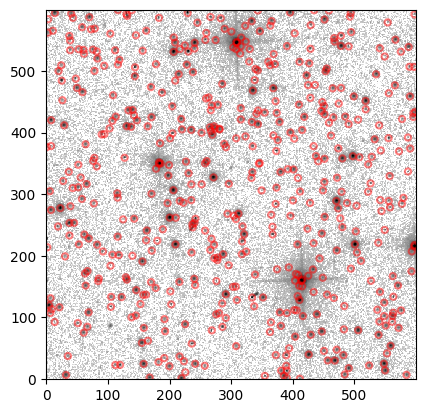

In [15]:
import numpy as np 
from photutils.aperture import CircularAperture

positions = np.transpose((sources1['xcentroid'], sources1['ycentroid']))
apertures = CircularAperture(positions, r=5.0)

plt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);

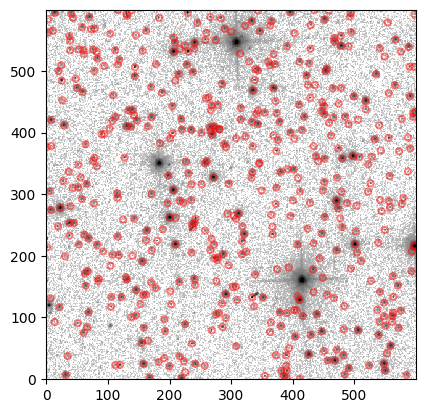

In [16]:
#only to remove certain dense spots


mask = np.zeros(section1.shape, dtype=bool)
#mask[y:y, x:x] = True
mask[100:130, 0:10] = True  #approximately selecting coords that have multiple false positives
mask[140:180,400:430] = True  #approximately selecting coords that have multiple false positives
mask[340:360, 160:200] = True  #approximately selecting coords that have multiple false positives
mask[530:560, 300:340] = True  #approximately selecting coords that have multiple false positives

sources1 = daofind(section1-median, mask=mask)
xpix = sources1['xcentroid']
ypix = sources1['ycentroid']

positions = np.transpose((xpix, ypix))
apertures = CircularAperture(positions, r=5.0)

plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);

In [17]:
print(apertures)

Aperture: CircularAperture
positions: [[4.11365189e+02, 3.97443984e-01],
            [2.19201167e+02, 1.12580315e+00],
            [3.90351566e+02, 1.61641130e+00],
            [1.67675002e+02, 2.33228448e+00],
            [3.54574005e+02, 5.01240413e+00],
            [3.85461154e+02, 5.40079964e+00],
            [3.18731766e+01, 6.49813446e+00],
            [4.84264263e+02, 7.35257226e+00],
            [5.84615107e+02, 6.75680899e+00],
            [2.25520489e+02, 1.08054263e+01],
            [3.81030767e+02, 1.36306822e+01],
            [3.90059471e+02, 1.37661719e+01],
            [5.49779555e+02, 1.39187447e+01],
            [4.90718094e+02, 1.75817762e+01],
            [1.99677543e+02, 2.06221938e+01],
            [2.57011954e+02, 2.13976039e+01],
            [3.89474565e+02, 2.13701654e+01],
            [5.23800836e+02, 2.18831601e+01],
            [1.11870353e+02, 2.27606719e+01],
            [1.19611305e+02, 2.29185539e+01],
            [1.57807040e+02, 2.44663602e+01],
       

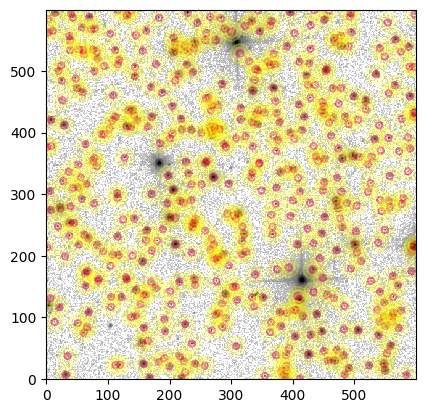

In [18]:
from photutils.aperture import CircularAnnulus, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
annulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);

In [19]:
aper_stats = ApertureStats(section1, annulus_aperture)
bkg_mean = aper_stats.mean
aper_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aper_area
star_data = aperture_photometry(section1, apertures)

star_data['total_bkg'] = total_bkg
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

 id  xcenter   ycenter   aperture_sum total_bkg 
       pix       pix                            
--- --------- ---------- ------------ ----------
  1 411.36519 0.39744398    4103.0749  583.07619
  2 219.20117  1.1258031     108298.1  1122.7125
  3 390.35157  1.6164113     30835.81  22652.269
  4   167.675  2.3322845    68065.423  97.672919
  5 354.57401  5.0124041    5510.6367  112.55312
  6 385.46115  5.4007996    99419.409  5936.8823
  7 31.873177  6.4981345    86331.023  30.364836
  8 484.26426  7.3525723    20506.824  23210.891
  9 584.61511   6.756809    20829.764  288.92445
...       ...        ...          ...        ...
483   129.844  592.46958    93132.225  7548.2895
484 13.775284   593.9895    122750.88  2066.8373
485 229.21828  594.04146    185086.62  1117.6341
486 494.04768  594.09473    15860.424 -321.55125
487 395.59983  594.80985    120187.99  1187.7023
488   343.079  598.25871    6419.2155   2466.003
489  458.6883   598.2368     1615.502  5607.1788
490 116.18916  598.8

In [20]:
from acstools import acszpt

#date = 2006-05-31 , 14:42:25
#exposure time = 35s
#filter = F606W
#instrument: Hubble Space Telescope: ACS-WFC

date = '2006-05-31'
instrument = 'WFC'
filter = 'F606W'

q = acszpt.Query(date= date, detector = instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date=date, detector=instrument,filt=filter)
filter_zpt=q_filter.fetch()

print(filter_zpt)


Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F606W   5919.7                    7.7949e-20   26.67  26.415  26.501


In [21]:
import math
zeropoint = 26.501
exposure_time = 35

magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint-(2.4*math.log10(abs(line[3]-line[4])/exposure_time)))
star_data['magnitude'] = magnitudes

star_data.pprint(max_lines=-1, max_width=-1)

 id  xcenter    ycenter   aperture_sum total_bkg      magnitude     
       pix        pix                                               
--- ---------- ---------- ------------ ---------- ------------------
  1  411.36519 0.39744398    4103.0749  583.07619  21.69506129883831
  2  219.20117  1.1258031     108298.1  1122.7125 18.134535202285534
  3  390.35157  1.6164113     30835.81  22652.269 20.815704305925614
  4    167.675  2.3322845    68065.423  97.672919 18.609236358227157
  5  354.57401  5.0124041    5510.6367  112.55312 21.249388251917466
  6  385.46115  5.4007996    99419.409  5936.8823  18.27701024535933
  7  31.873177  6.4981345    86331.023  30.364836 18.360329451884127
  8  484.26426  7.3525723    20506.824  23210.891 21.969921179014424
  9  584.61511   6.756809    20829.764  288.92445  19.85647962507889
 10  225.52049  10.805426    1659.2748  22876.046  19.82273300783705
 11  381.03077  13.630682    16555.328    10323.6 21.099702918402595
 12  390.05947  13.766172    71609

15.156611784048309	26.916878729669783	20.09260221827365	1.6565797943365117


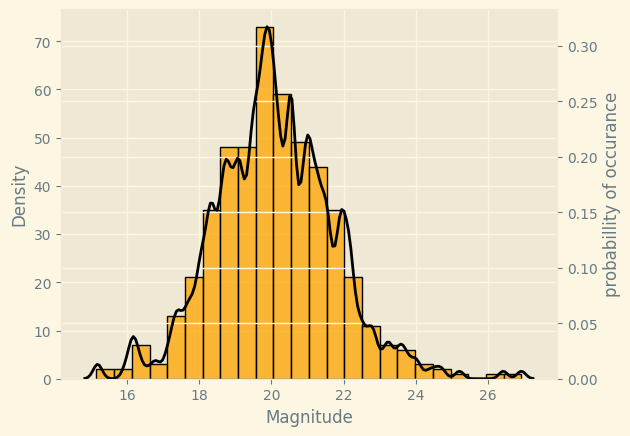

In [23]:
import seaborn as sns
import pandas as pd

mag_min = np.min(magnitudes)
mag_max = np.max(magnitudes)
mag_mid = np.mean(magnitudes)
mag_std = np.std(magnitudes)

print(f'{mag_min}\t{mag_max}\t{mag_mid}\t{mag_std}')

plt.style.use('Solarize_Light2')
mag_df = pd.DataFrame(magnitudes, columns=['Magnitude'])
fig, ax1 = plt.subplots()

ax1.set_ylabel('Density')
sns.histplot(data=mag_df, x='Magnitude', binwidth=0.5, color='orange', ax=ax1)
ax2 = ax1.twinx()

sns.kdeplot(data=mag_df, x='Magnitude', bw_adjust=0.25, color='black', ax=ax2)
ax2.set_ylabel('probabillity of occurance')
plt.show()

'''
sns.kdeplot(data=mag_df, x='Magnitude', bw_adjust=0.25, color='blue', ax=ax1)
ax1.set_ylabel('frequency')
ax1.grid(False)
plt.show()
'''
